In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set some display options
pd.set_option('max_colwidth', 400)

In [3]:
# Read the data into a Pandas DataFrame
df = pd.read_csv('resources/play_by_play_2024_cleaned.csv')
df.head()

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,return_touchdown,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa
0,1,2024_01_ARI_BUF,NaN,NaN,NaN,NaN,NaN,BUF 35,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Touchdown,NaN,NaN,0.000000
1,40,2024_01_ARI_BUF,ARI,BUF,BUF,35.0,NaN,BUF 35,0,kickoff,...,0.0,0.0,0.0,NaN,NaN,NaN,Touchdown,7:13,TOUCHDOWN,0.257819
2,61,2024_01_ARI_BUF,ARI,BUF,ARI,70.0,1.0,ARI 30,10,run,...,0.0,0.0,0.0,NaN,NaN,3.0,Touchdown,7:13,TOUCHDOWN,-0.200602
3,83,2024_01_ARI_BUF,ARI,BUF,ARI,67.0,2.0,ARI 33,7,pass,...,0.0,0.0,0.0,22.0,22.0,NaN,Touchdown,7:13,TOUCHDOWN,2.028874
4,108,2024_01_ARI_BUF,ARI,BUF,BUF,45.0,1.0,BUF 45,10,pass,...,0.0,0.0,0.0,9.0,9.0,NaN,Touchdown,7:13,TOUCHDOWN,0.754242


### Question #1
---
**Ruby Bhatia**
- How do teams perform offensively and defensively in NFL Week 1 games?


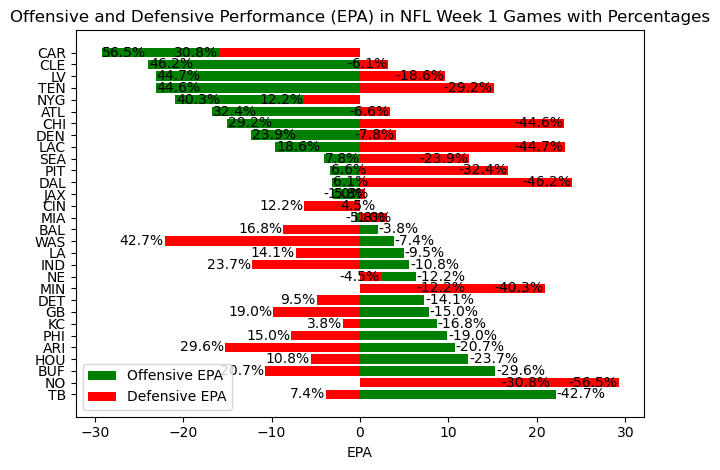

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = r'C:\repos\Project_3_Team_8\rbhatia\play_by_play_2024.csv'
df = pd.read_csv(file_path, low_memory=False)

# Filter data for Week 1 games
week1_data = df[df['week'] == 1]

# Calculate offensive performance (sum of EPA) for each team
offensive_performance = week1_data.groupby('posteam')['epa'].sum().reset_index().rename(columns={'epa': 'offensive_epa'})

# Calculate defensive performance (sum of EPA allowed) for each team
defensive_performance = week1_data.groupby('defteam')['epa'].sum().reset_index().rename(columns={'epa': 'defensive_epa'})

# Merge offensive and defensive performance data
performance = pd.merge(offensive_performance, defensive_performance, left_on='posteam', right_on='defteam', suffixes=('_offense', '_defense'))
performance = performance[['posteam', 'offensive_epa', 'defensive_epa']]

# Calculate percentages for offensive and defensive EPA
performance['offensive_percentage'] = 100 * (performance['offensive_epa'] / performance['offensive_epa'].sum())
performance['defensive_percentage'] = 100 * (performance['defensive_epa'] / performance['defensive_epa'].sum())

# Sort teams by offensive and defensive performance for visualization
performance_sorted = performance.sort_values(by='offensive_epa', ascending=False)

# Plot offensive EPA with percentages
bars = plt.barh(performance_sorted['posteam'], performance_sorted['offensive_epa'], color='green', label='Offensive EPA')

# Add offensive percentage labels
for bar, percentage in zip(bars, performance_sorted['offensive_percentage']):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{percentage:.1f}%', va='center')

# Plot defensive EPA (negate for visualization) with percentages
bars_defense = plt.barh(performance_sorted['posteam'], -performance_sorted['defensive_epa'], color='red', label='Defensive EPA')

# Add defensive percentage labels
for bar, percentage in zip(bars_defense, performance_sorted['defensive_percentage']):
    plt.text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, f'{-percentage:.1f}%', va='center', ha='right')

plt.xlabel('EPA')
plt.title('Offensive and Defensive Performance (EPA) in NFL Week 1 Games with Percentages')
plt.legend()

plt.tight_layout()
plt.show()


### Question #2
----
**Nathan Roller**
- What are tendencies for teams in specific down and distance situations? 


In [4]:
# Import dependencies
import scipy.stats as stats

In [5]:
# Display list of columns
df.columns

Index(['play_id', 'game_id', 'posteam', 'defteam', 'side_of_field',
       'yardline_100', 'down', 'yrdln', 'ydstogo', 'play_type', 'yards_gained',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'defteam_score', 'score_differential',
       'posteam_score_post', 'defteam_score_post', 'score_differential_post',
       'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'fumble_forced',
       'fumble_out_of_bounds', 'safety', 'penalty', 'tackled_for_loss',
       'fumble_lost', 'touchdown', 'pass_touchdown', 'rush_touchdown',
       'return_touchdown', 'field_goal_attempt', 'fumble', 'passing_yards',
       'receiving_yards', 'rushing_yards', 'fixed_drive_result',
       'drive_time_of_possession', 'drive_end_transition', 'qb_epa'],
      dtype='object')

In [6]:
# Filter only the run and pass plays (removing other plays which are not designed to achieve a first down)
df_filtered = df[df['play_type'].isin(['run', 'pass'])].reset_index(drop=True)

In [7]:
# Replace NaN with 0 in specific columns
columns_to_fill = ['yardline_100', 'down', 'ydstogo', 'receiving_yards', 'rushing_yards']
df_filtered[columns_to_fill] = df[columns_to_fill].fillna(0)

In [8]:
# Filter only the necessary columns for the analysis
df_down_distance = df_filtered[['yardline_100', 'down', 'ydstogo', 'play_type', 'receiving_yards', 'rushing_yards']]

# Confirm dataframe is what is wanted for the analysis
df_down_distance.head()

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards
0,0.0,0.0,0,run,0.0,0.0
1,35.0,0.0,0,pass,0.0,0.0
2,70.0,1.0,10,pass,0.0,3.0
3,67.0,2.0,7,run,22.0,0.0
4,45.0,1.0,10,run,9.0,0.0


In [9]:
# Change datatypes for columns to be int rather than double
df_down_distance = df_down_distance.astype({'yardline_100': 'int', 'down': 'int', 'receiving_yards': 'int', 'rushing_yards': 'int'})

# Confirm correct datatypes for each column
df_down_distance.dtypes

yardline_100        int32
down                int32
ydstogo             int64
play_type          object
receiving_yards     int32
rushing_yards       int32
dtype: object

In [10]:
# Calculate if enough yards were gained to get the first down
df_down_distance['net_yds'] = df_down_distance['receiving_yards'] + df_down_distance['rushing_yards'] - df_down_distance['ydstogo']

# Create column identifying whether or not the team got a first down
df_down_distance['got_first_down'] = np.where(df_down_distance['net_yds'] >= 0, 'yes', 'no')

# Confirm datafrome is updated correctly
df_down_distance.head()

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
0,0,0,0,run,0,0,0,yes
1,35,0,0,pass,0,0,0,yes
2,70,1,10,pass,0,3,-7,no
3,67,2,7,run,22,0,15,yes
4,45,1,10,run,9,0,-1,no


In [11]:
# Filter only first down plays
first_down = df_down_distance[df_down_distance['down'] == 1]

# Confirm dataframe is created correctly
first_down.head()

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
2,70,1,10,pass,0,3,-7,no
4,45,1,10,run,9,0,-1,no
6,34,1,10,pass,0,2,-8,no
9,22,1,10,run,0,0,-10,no
12,9,1,9,pass,0,4,-5,no


In [12]:
# Group plays for the histogram chart to see results for different parts of the field
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['Inside Opp 10', 'Opp 10-20', 'Opp 20-30', 'Opp 30-40', 'Opp 40-50', 'Own 40-50', 'Own 30-40', 'Own 20-30', 'Own 10-20', 'Inside Own 10']
fd = first_down.copy()
fd.loc[:, 'yardline_group'] = pd.cut(fd['yardline_100'], bins=bins, labels=labels)

# Create dataframe to store the data
crosstab_first = pd.crosstab(fd['yardline_group'], fd['play_type'])

In [13]:
# Create dataframe to show percentages
crosstab_first_normalized = crosstab_first.div(crosstab_first.sum(axis=1), axis=0) * 100
crosstab_first_normalized

play_type,pass,run
yardline_group,,
Inside Opp 10,62.162162,37.837838
Opp 10-20,64.000000,36.000000
Opp 20-30,65.454545,34.545455
Opp 30-40,53.703704,46.296296
Opp 40-50,40.322581,59.677419
Own 40-50,56.818182,43.181818
Own 30-40,50.000000,50.000000
Own 20-30,52.857143,47.142857
Own 10-20,70.588235,29.411765


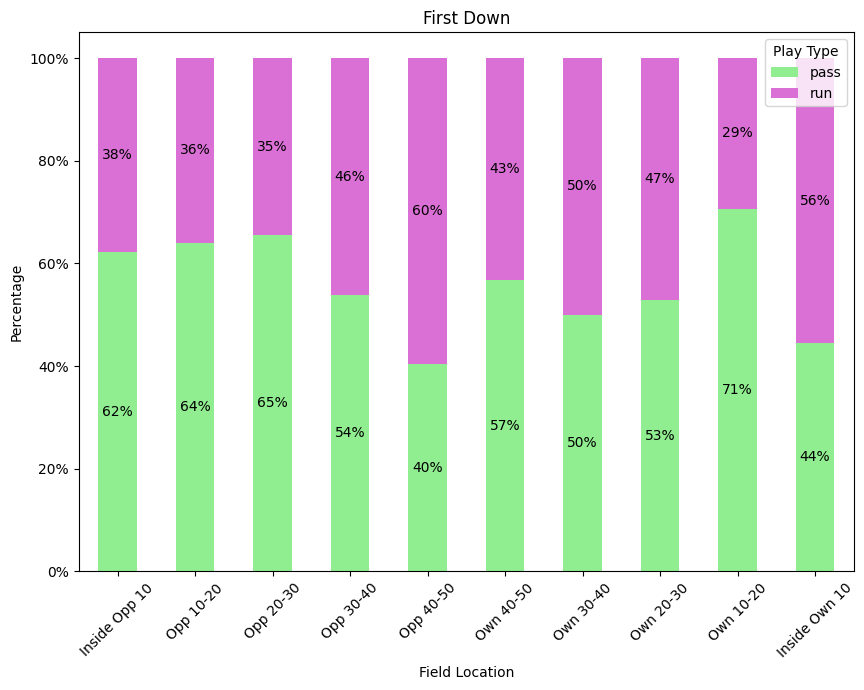

In [14]:
# Define colors for the 'pass' and 'run' categories
colors = {'pass': 'lightgreen', 'run': 'orchid'}

# Plot the stacked histogram using normalized data
ct_first = crosstab_first_normalized.plot(kind='bar', stacked=True, figsize=(10, 7), color=[colors[col] for col in crosstab_first_normalized.columns])

# Add titles and labels
plt.title('First Down')
plt.xlabel('Field Location')
plt.ylabel('Percentage')
plt.legend(title='Play Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format y-axis to include percentage symbol
ct_first.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Annotate the bars with the percentage values
for container in ct_first.containers:
    ct_first.bar_label(container, fmt='%.0f%%', label_type='center')

# Save the plot as an image
plt.savefig('images/first_down_bc.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [15]:
# Filter only second down plays
second_down = df_down_distance[df_down_distance['down'] == 2]

# Confirm dataframe is created correctly
second_down.head()

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
3,67,2,7,run,22,0,15,yes
5,36,2,1,run,0,2,1,yes
7,32,2,8,pass,0,2,-6,no
10,22,2,10,run,0,-3,-13,no
13,5,2,5,run,0,0,-5,no


In [16]:
# Group plays for the histogram chart to see results for different parts of the field
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['Inside Opp 10', 'Opp 10-20', 'Opp 20-30', 'Opp 30-40', 'Opp 40-50', 'Own 40-50', 'Own 30-40', 'Own 20-30', 'Own 10-20', 'Inside Own 10']
fd = second_down.copy()
fd.loc[:, 'yardline_group'] = pd.cut(fd['yardline_100'], bins=bins, labels=labels)

# Create dataframe to store the data
crosstab_second = pd.crosstab(fd['yardline_group'], fd['play_type'])

In [17]:
# Create dataframe to show percentages
crosstab_second_normalized = crosstab_second.div(crosstab_second.sum(axis=1), axis=0) * 100
crosstab_second_normalized

play_type,pass,run
yardline_group,,
Inside Opp 10,40.625000,59.375000
Opp 10-20,48.837209,51.162791
Opp 20-30,53.658537,46.341463
Opp 30-40,51.219512,48.780488
Opp 40-50,60.784314,39.215686
Own 40-50,46.153846,53.846154
Own 30-40,54.368932,45.631068
Own 20-30,48.076923,51.923077
Own 10-20,46.666667,53.333333


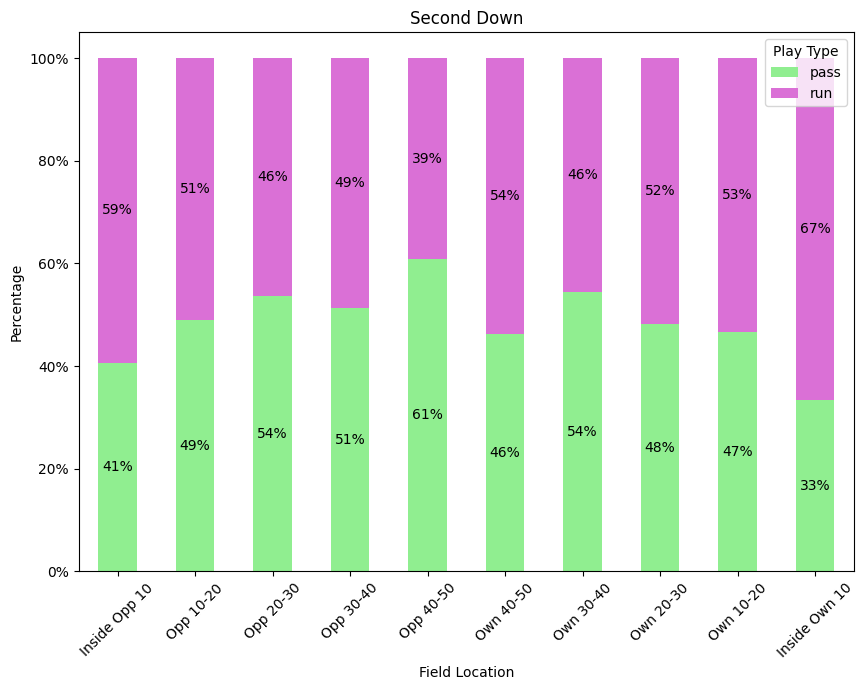

In [18]:
# Define colors for the 'pass' and 'run' categories
colors = {'pass': 'lightgreen', 'run': 'orchid'}

# Plot the stacked histogram using normalized data
ct_second = crosstab_second_normalized.plot(kind='bar', stacked=True, figsize=(10, 7), color=[colors[col] for col in crosstab_second_normalized.columns])

# Add titles and labels
plt.title('Second Down')
plt.xlabel('Field Location')
plt.ylabel('Percentage')
plt.legend(title='Play Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format y-axis to include percentage symbol
ct_second.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Annotate the bars with the percentage values
for container in ct_second.containers:
    ct_second.bar_label(container, fmt='%.0f%%', label_type='center')

# Save the plot as an image
plt.savefig('images/second_down_bc.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [19]:
# Filter only third down plays
third_down = df_down_distance[df_down_distance['down'] == 3]

# Confirm dataframe is created correctly
third_down.head()

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
8,30,3,6,run,8,0,2,yes
11,25,3,13,pass,0,6,-7,no
14,5,3,5,run,5,0,0,yes
23,65,3,4,pass,24,0,20,yes
29,13,3,6,run,2,0,-4,no


In [20]:
# Group plays for the histogram chart to see results for different parts of the field
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['Inside Opp 10', 'Opp 10-20', 'Opp 20-30', 'Opp 30-40', 'Opp 40-50', 'Own 40-50', 'Own 30-40', 'Own 20-30', 'Own 10-20', 'Inside Own 10']
fd = third_down.copy()
fd.loc[:, 'yardline_group'] = pd.cut(fd['yardline_100'], bins=bins, labels=labels)

# Create dataframe to store the data
crosstab_third = pd.crosstab(fd['yardline_group'], fd['play_type'])

In [21]:
# Create dataframe to show percentages
crosstab_third_normalized = crosstab_third.div(crosstab_third.sum(axis=1), axis=0) * 100
crosstab_third_normalized

play_type,pass,run
yardline_group,,
Inside Opp 10,72.000000,28.000000
Opp 10-20,70.370370,29.629630
Opp 20-30,56.521739,43.478261
Opp 30-40,53.125000,46.875000
Opp 40-50,67.857143,32.142857
Own 40-50,62.500000,37.500000
Own 30-40,50.847458,49.152542
Own 20-30,57.500000,42.500000
Own 10-20,50.000000,50.000000


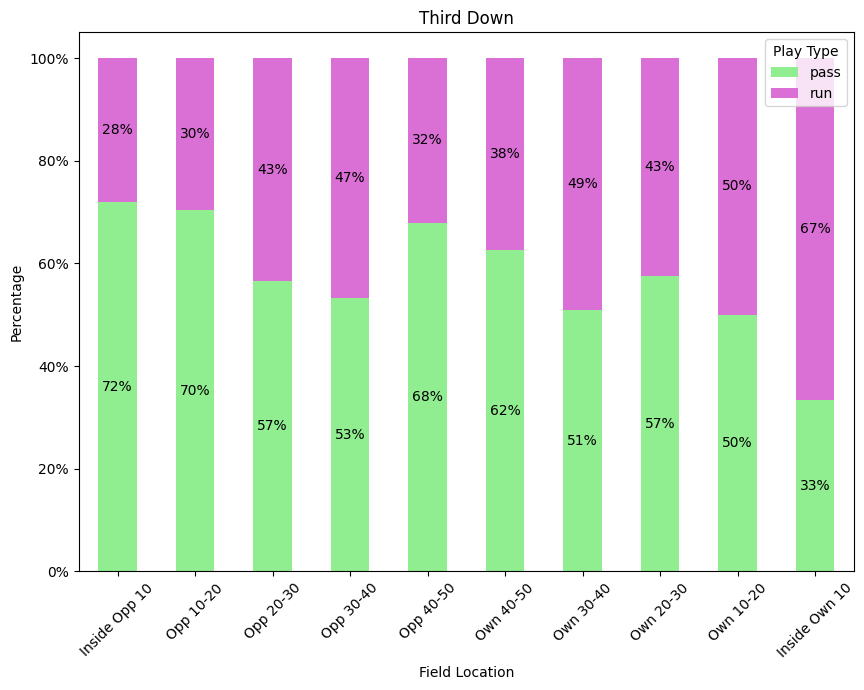

In [22]:
# Define colors for the 'pass' and 'run' categories
colors = {'pass': 'lightgreen', 'run': 'orchid'}

# Plot the stacked histogram using normalized data
ct_third = crosstab_third_normalized.plot(kind='bar', stacked=True, figsize=(10, 7), color=[colors[col] for col in crosstab_third_normalized.columns])

# Add titles and labels
plt.title('Third Down')
plt.xlabel('Field Location')
plt.ylabel('Percentage')
plt.legend(title='Play Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format y-axis to include percentage symbol
ct_third.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Annotate the bars with the percentage values
for container in ct_third.containers:
    ct_third.bar_label(container, fmt='%.0f%%', label_type='center')

# Save the plot as an image
plt.savefig('images/third_down_bc.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [23]:
# Filter only fourth down plays
fourth_down = df_down_distance[df_down_distance['down'] == 4]

# Confirm dataframe is created correctly
fourth_down.head()

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
31,11,4,4,run,0,0,-4,no
43,19,4,19,pass,0,0,-19,no
93,74,4,14,run,0,0,-14,no
97,66,4,7,pass,0,0,-7,no
103,12,4,1,pass,0,1,0,yes


In [24]:
# Group plays for the histogram chart to see results for different parts of the field
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['Inside Opp 10', 'Opp 10-20', 'Opp 20-30', 'Opp 30-40', 'Opp 40-50', 'Own 40-50', 'Own 30-40', 'Own 20-30', 'Own 10-20', 'Inside Own 10']
fd = fourth_down.copy()
fd.loc[:, 'yardline_group'] = pd.cut(fd['yardline_100'], bins=bins, labels=labels)

# Create dataframe to store the data
crosstab_fourth = pd.crosstab(fd['yardline_group'], fd['play_type'])

In [25]:
# Create dataframe to show percentages
crosstab_fourth_normalized = crosstab_fourth.div(crosstab_fourth.sum(axis=1), axis=0) * 100
crosstab_fourth_normalized

play_type,pass,run
yardline_group,,
Inside Opp 10,53.846154,46.153846
Opp 10-20,62.500000,37.500000
Opp 20-30,62.500000,37.500000
Opp 30-40,38.888889,61.111111
Opp 40-50,47.058824,52.941176
Own 40-50,60.000000,40.000000
Own 30-40,55.172414,44.827586
Own 20-30,66.666667,33.333333
Own 10-20,75.000000,25.000000


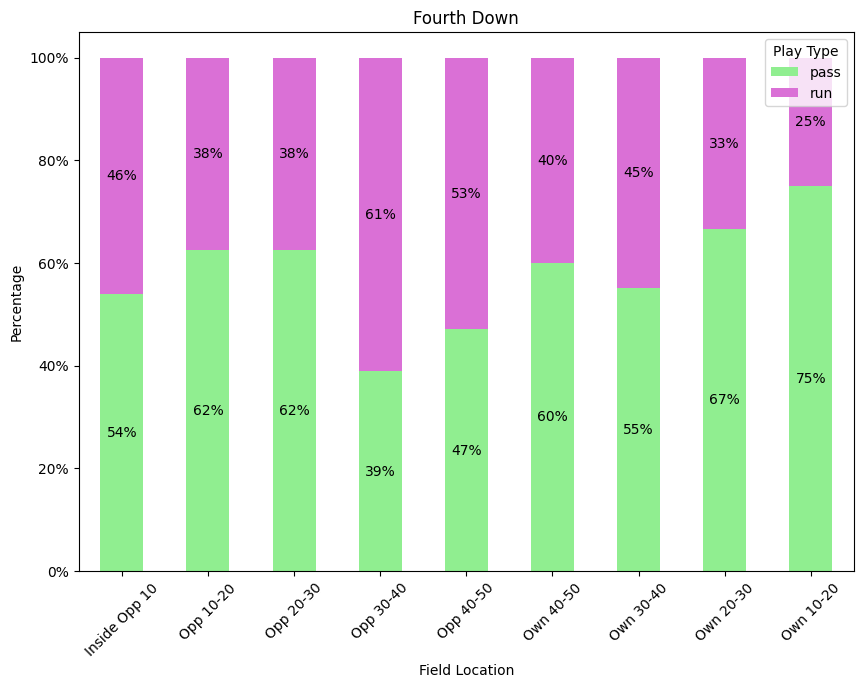

In [26]:
# Define colors for the 'pass' and 'run' categories
colors = {'pass': 'lightgreen', 'run': 'orchid'}

# Plot the stacked histogram using normalized data
ct_fourth = crosstab_fourth_normalized.plot(kind='bar', stacked=True, figsize=(10, 7), color=[colors[col] for col in crosstab_fourth_normalized.columns])

# Add titles and labels
plt.title('Fourth Down')
plt.xlabel('Field Location')
plt.ylabel('Percentage')
plt.legend(title='Play Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Format y-axis to include percentage symbol
ct_fourth.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Annotate the bars with the percentage values
for container in ct_fourth.containers:
    ct_fourth.bar_label(container, fmt='%.0f%%', label_type='center')

# Save the plot as an image
plt.savefig('images/fourth_down_bc.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Question #3 
---
**Justin Nolan**
- How do different team statistics correlate with winning outcomes in Week 1 games?


In [4]:
# Fill NaN values in 'passing_yards' and 'rushing_yards' with 0
df['passing_yards'] = df['passing_yards'].fillna(0)
df['rushing_yards'] = df['rushing_yards'].fillna(0)

# Create a new column for total yards gained (passing + rushing)
df['total_yards'] = df['passing_yards'] + df['rushing_yards']

# Group by the team with possession (posteam) and calculate total yards
yards_per_team = df.groupby('posteam').agg({
    'total_yards': 'sum'
}).reset_index()

# Sort the teams by total yards, from highest to lowest
yards_per_team = yards_per_team.sort_values('total_yards', ascending=False)

# List of teams that won (using team abbreviations)
winning_teams = ['KC', 'PHI', 'LAC', 'BUF', 'NE', 'MIN', 'CHI', 'NO', 'PIT', 'MIA', 'HOU', 'SEA', 'DAL', 'TB', 'DET']

# Define color mapping for win/loss: Blue for Win, Red for Loss
colors = ['blue' if team in winning_teams else 'red' for team in yards_per_team['posteam']]

# Display the total yards gained by each team
print("Total yards gained by each team in Week 1 (sorted by highest to lowest):")
print(yards_per_team)

Total yards gained by each team in Week 1 (sorted by highest to lowest):
   posteam  total_yards
2      BAL        458.0
12     HOU        447.0
11      GB        423.0
24     PHI        422.0
19     MIA        419.0
27      TB        401.0
16      LA        400.0
22      NO        380.0
10     DET        380.0
15      KC        363.0
3      BUF        362.0
18      LV        328.0
29     WAS        322.0
17     LAC        320.0
20     MIN        319.0
26     SEA        317.0
13     IND        316.0
25     PIT        293.0
21      NE        291.0
14     JAX        290.0
0      ARI        286.0
8      DAL        281.0
28     TEN        267.0
7      CLE        262.0
23     NYG        260.0
1      ATL        244.0
9      DEN        237.0
6      CIN        234.0
4      CAR        219.0
5      CHI        177.0


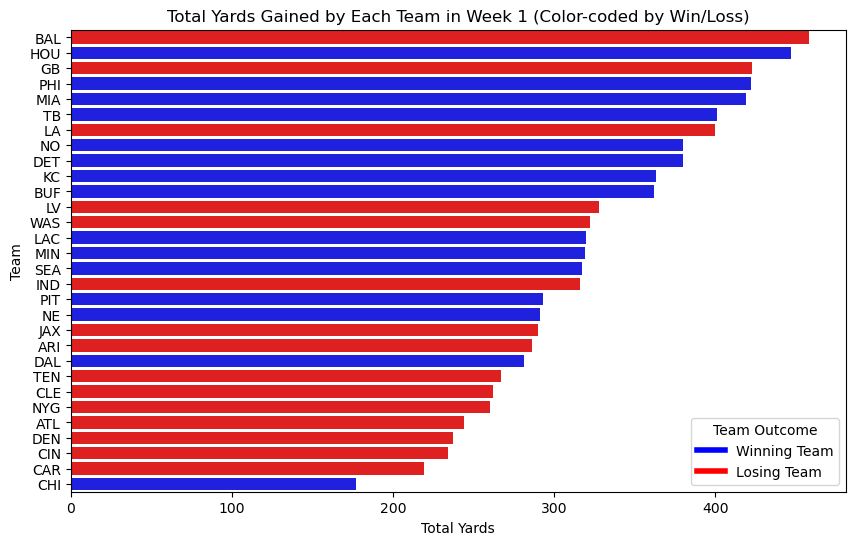

In [5]:
# Visualization: Total yards gained by each team, color-coded by win/loss
plt.figure(figsize=(10, 6))
bars = sns.barplot(x='total_yards', y='posteam', data=yards_per_team, palette=colors)
plt.title('Total Yards Gained by Each Team in Week 1 (Color-coded by Win/Loss)')
plt.xlabel('Total Yards')
plt.ylabel('Team')

# Adding legend manually
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=4, label='Winning Team'),
                   Line2D([0], [0], color='red', lw=4, label='Losing Team')]
plt.legend(handles=legend_elements, title="Team Outcome", loc="lower right")

# Save plot as PNG before displaying
plt.savefig('images/total_yards_per_team.png')
plt.show()
plt.close()

In [6]:
# Create a column indicating if the team won (1 for win, 0 for loss)
yards_per_team['win'] = yards_per_team['posteam'].apply(lambda team: 1 if team in winning_teams else 0)

# Calculate average yards for winning teams and losing teams
avg_yards_winning = yards_per_team[yards_per_team['win'] == 1]['total_yards'].mean()
avg_yards_losing = yards_per_team[yards_per_team['win'] == 0]['total_yards'].mean()

# Display the results
print(f"Average Yards Gained by Winning Teams: {avg_yards_winning:.2f}")
print(f"Average Yards Gained by Losing Teams: {avg_yards_losing:.2f}")


Average Yards Gained by Winning Teams: 344.80
Average Yards Gained by Losing Teams: 303.07


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


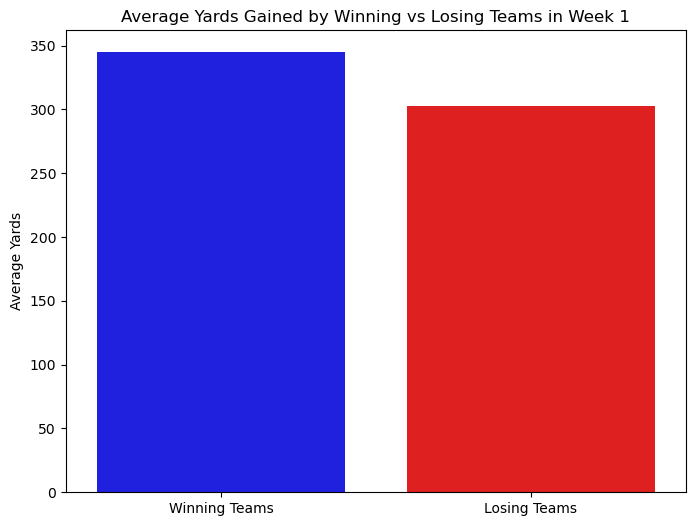

In [7]:
# Visualization: Bar plot to compare average yards gained by winning and losing teams
plt.figure(figsize=(8, 6))
sns.barplot(x=['Winning Teams', 'Losing Teams'], y=[avg_yards_winning, avg_yards_losing], palette=['blue', 'red'])
plt.title('Average Yards Gained by Winning vs Losing Teams in Week 1')
plt.ylabel('Average Yards')

# Save plot as PNG before displaying
plt.savefig('images/avg_yards_winning_vs_losing.png')
plt.show()
plt.close()

In [8]:
# Fill NaN values in the 'penalty' column with 0 to ensure accurate summing
df['penalty'] = df['penalty'].fillna(0)

# Group by the team with possession (posteam) and calculate total penalties
penalties_per_team = df.groupby('posteam')['penalty'].sum().reset_index()

# Sort the teams by total penalties, from highest to lowest
penalties_per_team = penalties_per_team.sort_values('penalty', ascending=False)

# Display the total penalties by each team
print("Total penalties committed by each team in Week 1 (sorted by highest to lowest):")
print(penalties_per_team)

Total penalties committed by each team in Week 1 (sorted by highest to lowest):
   posteam  penalty
7      CLE     13.0
11      GB     12.0
3      BUF     12.0
26     SEA     11.0
19     MIA      9.0
8      DAL      9.0
22      NO      9.0
20     MIN      8.0
1      ATL      8.0
14     JAX      8.0
23     NYG      8.0
27      TB      8.0
5      CHI      8.0
12     HOU      7.0
28     TEN      7.0
16      LA      7.0
4      CAR      7.0
15      KC      7.0
25     PIT      6.0
17     LAC      6.0
2      BAL      6.0
24     PHI      5.0
29     WAS      5.0
10     DET      5.0
6      CIN      4.0
21      NE      3.0
18      LV      3.0
9      DEN      3.0
13     IND      2.0
0      ARI      2.0


In [9]:
# Fill NaN values in the 'penalty' column with 0 to ensure accurate summing
df['penalty'] = df['penalty'].fillna(0)

# Group by the team with possession (posteam) and calculate total penalties
penalties_per_team = df.groupby('posteam')['penalty'].sum().reset_index()

# List of teams that won (using team abbreviations)
winning_teams = ['KC', 'PHI', 'LAC', 'BUF', 'NE', 'MIN', 'CHI', 'NO', 'PIT', 'MIA', 'HOU', 'SEA', 'DAL', 'TB', 'DET']

# Create a column indicating if the team won (1 for win, 0 for loss)
penalties_per_team['win'] = penalties_per_team['posteam'].apply(lambda team: 1 if team in winning_teams else 0)

# Calculate average penalties for winning teams and losing teams
avg_penalties_winning = penalties_per_team[penalties_per_team['win'] == 1]['penalty'].mean()
avg_penalties_losing = penalties_per_team[penalties_per_team['win'] == 0]['penalty'].mean()

# Display the results
print(f"Average Penalties for Winning Teams: {avg_penalties_winning:.2f}")
print(f"Average Penalties for Losing Teams: {avg_penalties_losing:.2f}")

Average Penalties for Winning Teams: 7.53
Average Penalties for Losing Teams: 6.33


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


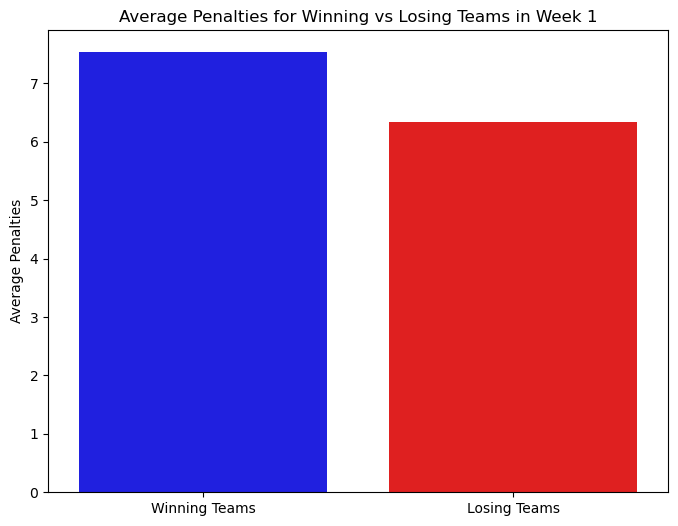

<Figure size 640x480 with 0 Axes>

In [14]:
# Visualization: Bar plot to compare average penalties for winning and losing teams
plt.figure(figsize=(8, 6))
sns.barplot(x=['Winning Teams', 'Losing Teams'], y=[avg_penalties_winning, avg_penalties_losing], palette=['blue', 'red'])
plt.title('Average Penalties for Winning vs Losing Teams in Week 1')
plt.ylabel('Average Penalties')

plt.show()

# Save plot as PNG before displaying
plt.savefig('images/avg_penalties_winning_vs_losing.png')
plt.show()
plt.close()

In [11]:
# Count turnovers from 'fixed_drive_result' where the value is 'Turnover',
# ensuring no duplicates by checking 'drive_time_of_possession'
df['turnover'] = df.apply(
    lambda row: 1 if row['fixed_drive_result'] == 'Turnover' else 0, axis=1
)

# Remove duplicate turnovers within the same team and drive time
df_turnover_deduped = df.drop_duplicates(subset=['posteam', 'drive_time_of_possession', 'fixed_drive_result'])

# Group by the team with possession (posteam) and calculate turnovers without duplicates
turnovers = df_turnover_deduped.groupby('posteam')['turnover'].sum().reset_index()

# Now calculate touchdowns and field goals without deduplicating
touchdowns = df.groupby('posteam')['touchdown'].sum().reset_index()
field_goals = df.groupby('posteam')['field_goal_attempt'].sum().reset_index()

# Merge the results to get the complete team stats
team_stats = touchdowns.merge(field_goals, on='posteam').merge(turnovers, on='posteam')

# Rename columns for clarity
team_stats.columns = ['Team', 'Total Touchdowns', 'Total Field Goals', 'Total Turnovers']

# Display the resulting DataFrame
team_stats

,Team,Total Touchdowns,Total Field Goals,Total Turnovers
0,ARI,3.0,2.0,1
1,ATL,1.0,1.0,3
2,BAL,2.0,3.0,1
3,BUF,4.0,2.0,1
4,CAR,1.0,1.0,3
5,CHI,0.0,3.0,0
6,CIN,1.0,1.0,1
7,CLE,3.0,1.0,2
8,DAL,2.0,4.0,0
9,DEN,1.0,3.0,3


In [12]:
# List of teams that won (using team abbreviations)
winning_teams = ['KC', 'PHI', 'LAC', 'BUF', 'NE', 'MIN', 'CHI', 'NO', 'PIT', 'MIA', 'HOU', 'SEA', 'DAL', 'TB', 'DET']

# Count turnovers from 'fixed_drive_result' where the value is 'Turnover'
df['turnover'] = df.apply(
    lambda row: 1 if row['fixed_drive_result'] == 'Turnover' else 0, axis=1
)

# Remove duplicate turnovers within the same team and drive time
df_turnover_deduped = df.drop_duplicates(subset=['posteam', 'drive_time_of_possession', 'fixed_drive_result'])

# Group by the team with possession (posteam) and calculate total turnovers
turnovers_per_team = df_turnover_deduped.groupby('posteam')['turnover'].sum().reset_index()

# Add a column indicating if the team won (1 for win, 0 for loss)
turnovers_per_team['win'] = turnovers_per_team['posteam'].apply(lambda team: 1 if team in winning_teams else 0)

# Calculate average turnovers for winning teams and losing teams
avg_turnovers_winning = turnovers_per_team[turnovers_per_team['win'] == 1]['turnover'].mean()
avg_turnovers_losing = turnovers_per_team[turnovers_per_team['win'] == 0]['turnover'].mean()

# Display the results
print(f"Average Turnovers for Winning Teams: {avg_turnovers_winning:.2f}")
print(f"Average Turnovers for Losing Teams: {avg_turnovers_losing:.2f}")


Average Turnovers for Winning Teams: 0.60
Average Turnovers for Losing Teams: 1.60


/opt/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


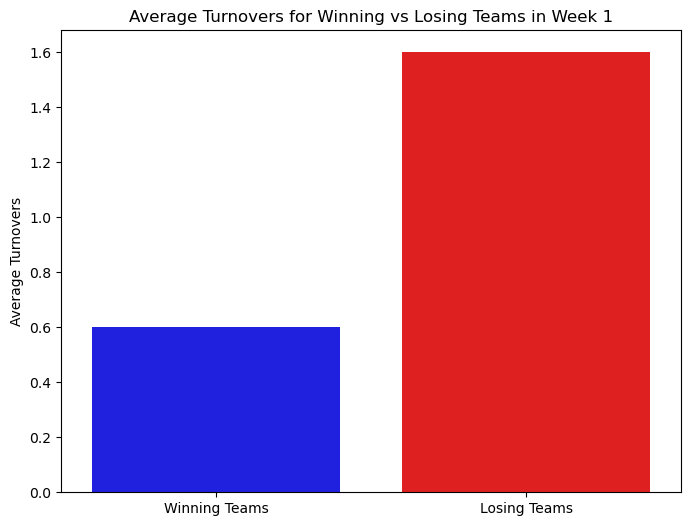

In [13]:
# Visualization: Bar plot to compare average turnovers for winning and losing teams
plt.figure(figsize=(8, 6))
sns.barplot(x=['Winning Teams', 'Losing Teams'], y=[avg_turnovers_winning, avg_turnovers_losing], palette=['blue', 'red'])
plt.title('Average Turnovers for Winning vs Losing Teams in Week 1')
plt.ylabel('Average Turnovers')

# Save plot as PNG before displaying
plt.savefig('images/avg_turnovers_winning_vs_losing.png')
plt.show()
plt.close()

### Question #4
---
**Darell Johnson**

- What are the conversion rates for possession downs? What tendencies did you identify?

In [51]:
money_down = df[(df['down'].isin([3, 4])) & (df['ydstogo'] <= 3)].copy()  
money_down.loc[:, 'yards_gained'] = money_down[['passing_yards', 'rushing_yards']].sum(axis=1)


money_down.loc[:, 'result'] = money_down.apply(
    lambda row: 'first_down' if row['yards_gained'] >= row['ydstogo'] else 'unsuccesful_attempt',
    axis=1
)

money_down

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa,result
63,1622,2024_01_ARI_BUF,BUF,ARI,BUF,61.0,3.0,BUF 39,1,no_play,...,0.0,0.0,NaN,NaN,NaN,Touchdown,2:21,TOUCHDOWN,-0.800535,unsuccesful_attempt
102,2608,2024_01_ARI_BUF,BUF,ARI,ARI,13.0,3.0,ARI 13,2,run,...,0.0,0.0,NaN,NaN,1.0,Touchdown,2:48,TOUCHDOWN,-0.816518,unsuccesful_attempt
103,2632,2024_01_ARI_BUF,BUF,ARI,ARI,12.0,4.0,ARI 12,1,run,...,0.0,0.0,NaN,NaN,1.0,Touchdown,2:48,TOUCHDOWN,1.343717,first_down
123,3124,2024_01_ARI_BUF,BUF,ARI,ARI,37.0,4.0,ARI 37,2,run,...,0.0,0.0,NaN,NaN,5.0,Touchdown,4:48,TOUCHDOWN,2.453890,first_down
148,3741,2024_01_ARI_BUF,BUF,ARI,ARI,20.0,3.0,ARI 20,2,run,...,0.0,0.0,NaN,NaN,-1.0,Field goal,2:34,FIELD_GOAL,-1.196253,unsuccesful_attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,2155,2024_01_WAS_TB,WAS,TB,TB,40.0,3.0,TB 40,1,run,...,0.0,0.0,NaN,NaN,0.0,Missed field goal,5:39,MISSED_FG,-1.728518,unsuccesful_attempt
2503,2189,2024_01_WAS_TB,WAS,TB,TB,40.0,4.0,TB 40,1,run,...,0.0,0.0,NaN,NaN,2.0,Missed field goal,5:39,MISSED_FG,2.318735,first_down
2523,2695,2024_01_WAS_TB,TB,WAS,TB,69.0,3.0,TB 31,3,pass,...,0.0,0.0,NaN,NaN,NaN,Punt,1:32,PUNT,-2.572418,unsuccesful_attempt
2559,3603,2024_01_WAS_TB,TB,WAS,WAS,1.0,3.0,WAS 1,1,pass,...,0.0,0.0,1.0,1.0,NaN,Touchdown,7:38,TOUCHDOWN,1.343011,first_down


In [53]:
money_down = money_down[['play_id', 'down', 'ydstogo', 'yards_gained','play_type', 'air_yards', 'result']]
money_down

,play_id,down,ydstogo,yards_gained,play_type,air_yards,result
63,1622,3.0,1,0.0,no_play,NaN,unsuccesful_attempt
102,2608,3.0,2,1.0,run,NaN,unsuccesful_attempt
103,2632,4.0,1,1.0,run,NaN,first_down
123,3124,4.0,2,5.0,run,NaN,first_down
148,3741,3.0,2,-1.0,run,NaN,unsuccesful_attempt
...,...,...,...,...,...,...,...
2502,2155,3.0,1,0.0,run,NaN,unsuccesful_attempt
2503,2189,4.0,1,2.0,run,NaN,first_down
2523,2695,3.0,3,0.0,pass,NaN,unsuccesful_attempt
2559,3603,3.0,1,1.0,pass,1.0,first_down


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

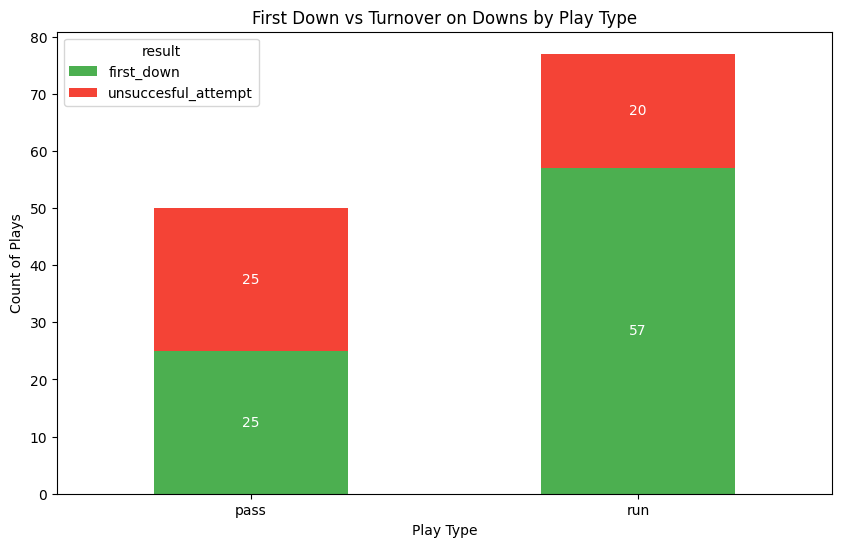

In [57]:
import os
import matplotlib.pyplot as plt

def create_stacked_bar_chart_with_labels(data, save_path):
    # Group by play_type and result to get counts
    grouped = data.groupby(['play_type', 'result']).size().unstack()

    custom_colors = ['#4CAF50', '#F44336']
    ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=custom_colors)
    
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fmt='%d', color='white', fontsize=10)
    
    plt.title('First Down vs Turnover on Downs by Play Type')
    plt.xlabel('Play Type')
    plt.ylabel('Count of Plays')
    plt.xticks(rotation=0)


    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


filtered_data = money_down[money_down['play_type'].isin(['run', 'pass'])]


images_folder = r'C:\Repos\NFL_2024_Week_1\Images'
image_path = os.path.join(images_folder, 'Money_Down.png')


create_stacked_bar_chart_with_labels(filtered_data, image_path)


In [58]:
first_down_pass = money_down[(money_down['result'] == 'first_down') & (money_down['play_type'] == 'pass')]
first_down_pass.head()

,play_id,down,ydstogo,yards_gained,play_type,air_yards,result
274,2717,3.0,3,10.0,pass,5.0,first_down
767,1786,3.0,2,19.0,pass,17.0,first_down
862,4030,4.0,2,7.0,pass,6.0,first_down
875,4333,3.0,3,5.0,pass,5.0,first_down
930,988,3.0,1,8.0,pass,6.0,first_down


In [59]:
first_down_pass = money_down[(money_down['result'] == 'first_down') & (money_down['play_type'] == 'pass')].copy()
first_down_pass.loc[:, 'air_yard_category'] = pd.cut(
    first_down_pass['air_yards'], 
    bins=[-float('inf'), 0, 3, 7, float('inf')], 
    labels=['<= 0', '> 0 and <= 3', '> 3 and <= 7', '> 7']
)
grouped_by_air_yards = first_down_pass.groupby('air_yard_category', observed=True).size()
grouped_by_air_yards

air_yard_category
<= 0            3
> 0 and <= 3    7
> 3 and <= 7    9
> 7             6
dtype: int64

C:\Users\dljoh\AppData\Local\Temp\ipykernel_25428\2522255085.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_air_yards = first_down_pass.groupby('air_yard_category').size()


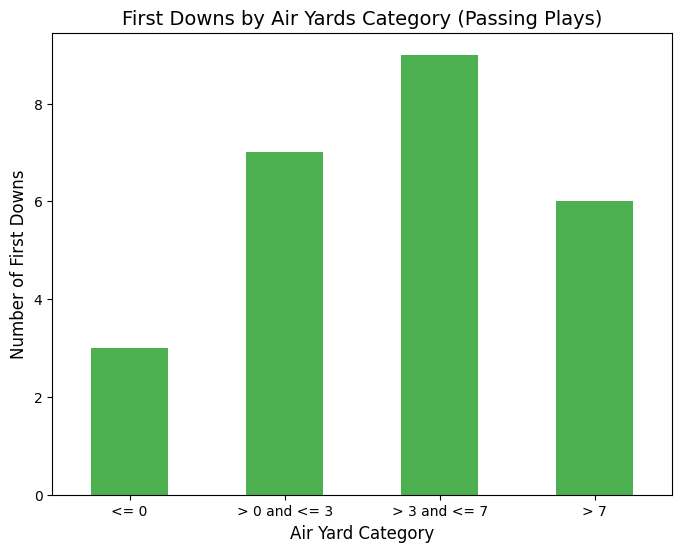

In [63]:
import matplotlib.pyplot as plt

grouped_by_air_yards = first_down_pass.groupby('air_yard_category').size()

plt.figure(figsize=(8, 6))
grouped_by_air_yards.plot(kind='bar', color='#4CAF50')

plt.title('First Downs by Air Yards Category (Passing Plays)', fontsize=14)
plt.xlabel('Air Yard Category', fontsize=12)
plt.ylabel('Number of First Downs', fontsize=12)
images_folder = r'C:\Repos\NFL_2024_Week_1\Images'
image_path = os.path.join(images_folder, 'Successful Passing.png')  # You can change the file name and format if needed
    
plt.savefig(image_path, bbox_inches='tight')
# Show the plot
plt.xticks(rotation=0)  # Ensures the category labels are horizontal
plt.show()


In [64]:
money_down_pass = money_down[(money_down['play_type'] == 'pass')]
money_down_pass.head()

,play_id,down,ydstogo,yards_gained,play_type,air_yards,result
213,1265,4.0,3,1.0,pass,-1.0,unsuccesful_attempt
274,2717,3.0,3,10.0,pass,5.0,first_down
453,2920,3.0,3,0.0,pass,3.0,unsuccesful_attempt
706,159,3.0,2,0.0,pass,5.0,unsuccesful_attempt
726,689,3.0,3,0.0,pass,5.0,unsuccesful_attempt


In [67]:
# Filter for 'pass' play types
money_down_pass = money_down[money_down['play_type'] == 'pass'].copy()

# Categorize 'air_yards' into bins with appropriate labels
money_down_pass.loc[:, 'air_yard_category'] = pd.cut(
    money_down_pass['air_yards'], 
    bins=[-float('inf'), 0, 3, 7, float('inf')], 
    labels=['<= 0', '> 0 and <= 3', '> 3 and <= 7', '> 7']
)

# Group by the 'air_yard_category' and count the occurrences
money_down_attempts = money_down_pass.groupby('air_yard_category', observed=True).size()

# Display the resu
money_down_attempts

air_yard_category
<= 0             9
> 0 and <= 3    10
> 3 and <= 7    15
> 7             12
dtype: int64

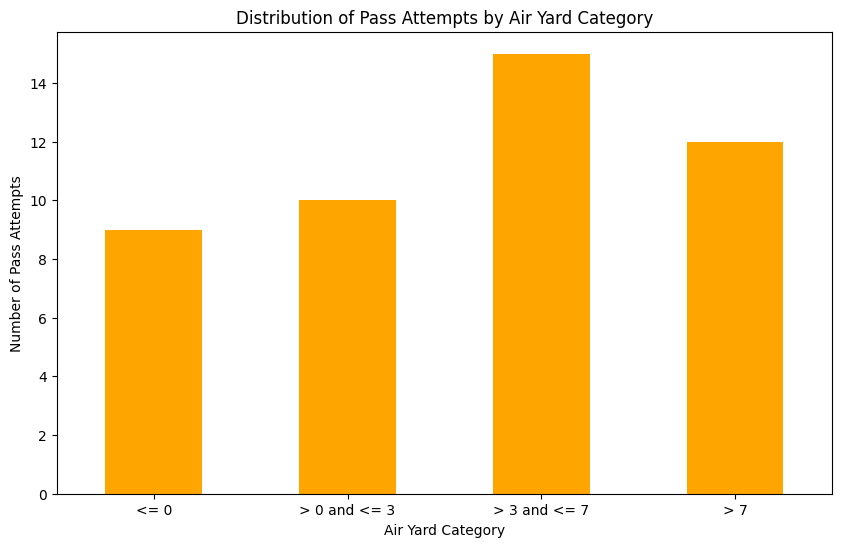

In [69]:
# Filter for 'pass' play types
money_down_pass = money_down[money_down['play_type'] == 'pass'].copy()

# Categorize 'air_yards' into bins with appropriate labels
money_down_pass.loc[:, 'air_yard_category'] = pd.cut(
    money_down_pass['air_yards'], 
    bins=[-float('inf'), 0, 3, 7, float('inf')], 
    labels=['<= 0', '> 0 and <= 3', '> 3 and <= 7', '> 7']
)

# Group by the 'air_yard_category' and count the occurrences
money_down_attempts = money_down_pass.groupby('air_yard_category', observed=True).size()

# Create a bar chart
money_down_attempts.plot(kind='bar', color='orange', figsize=(10, 6))

# Add titles and labels
plt.title('Distribution of Pass Attempts by Air Yard Category')
plt.xlabel('Air Yard Category')
plt.ylabel('Number of Pass Attempts')
plt.xticks(rotation=0)

images_folder = r'C:\Repos\NFL_2024_Week_1\Images'
image_path = os.path.join(images_folder, 'Pass Attemtpts.png')  # You can change the file name and format if needed
    
plt.savefig(image_path, bbox_inches='tight')

# Display the bar chart
plt.show()

C:\Users\dljoh\AppData\Local\Temp\ipykernel_25428\4142663514.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  money_down_grouped = money_down_pass.groupby(['air_yard_category', 'result']).size().unstack()


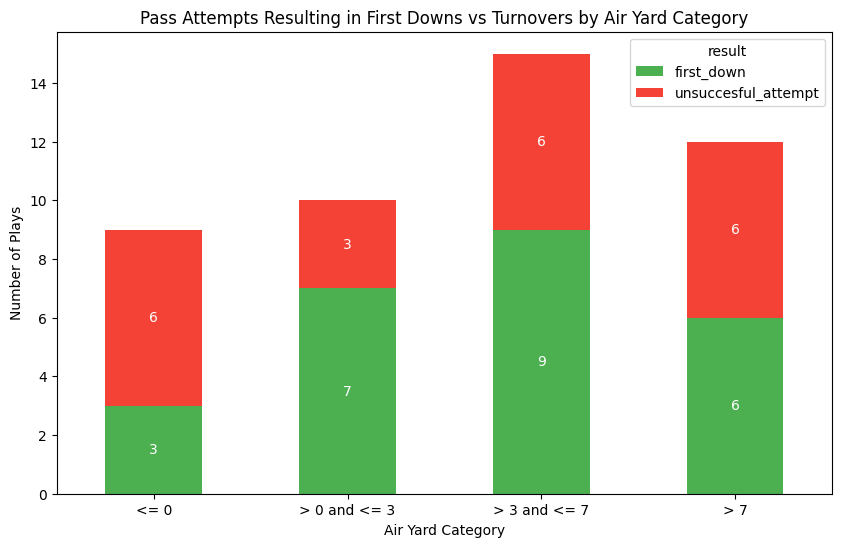

In [71]:
import matplotlib.pyplot as plt

# Filter for 'pass' play types
money_down_pass = money_down[money_down['play_type'] == 'pass'].copy()

# Categorize 'air_yards' into bins with appropriate labels
money_down_pass.loc[:, 'air_yard_category'] = pd.cut(
    money_down_pass['air_yards'], 
    bins=[-float('inf'), 0, 3, 7, float('inf')], 
    labels=['<= 0', '> 0 and <= 3', '> 3 and <= 7', '> 7']
)

# Group by air_yard_category and result (e.g., first down, turnover on downs)
money_down_grouped = money_down_pass.groupby(['air_yard_category', 'result']).size().unstack()

# Create a stacked bar chart
ax = money_down_grouped.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#4CAF50', '#F44336'])

# Add titles and labels
plt.title('Pass Attempts Resulting in First Downs vs Turnovers by Air Yard Category')
plt.xlabel('Air Yard Category')
plt.ylabel('Number of Plays')
plt.xticks(rotation=0)

# Add data labels
for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%d', color='white', fontsize=10)

images_folder = r'C:\Repos\NFL_2024_Week_1\Images'
image_path = os.path.join(images_folder, 'First Down or Nah.png')  # You can change the file name and format if needed
    
plt.savefig(image_path, bbox_inches='tight')
# Display the chart
plt.show()
